In [27]:
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Input, Dense, Flatten, Convolution2D, Conv2DTranspose, Dropout
from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.callbacks import TensorBoard

def config():
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    set_session(tf.Session(config=config))

config()
    
print('libs loaded')

libs loaded


In [28]:
def get_list():
    X_filenames = []
    path = '../input/train/'
    for root, dirs, files in os.walk(path):
        for name in files:
            X_filenames.append(os.path.join(root, name).split('/')[-1])
    return X_filenames
X_filenames = get_list()

(2, 128, 128, 3)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
14931


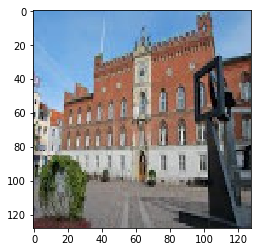

In [29]:

def load_batch(batch_size):
    path = '../input/train/'
    X_list = []
    Y_list = []
    for i in range(batch_size):
        name = random.choice(X_filenames)
        X_list.append(name)
        Y_list.append(int(name.split('.')[1]))
        
    #print(X_list)
    #print(Y_list)
    
    size = 128
    data_shape = (batch_size, size, size, 3)
    X = np.zeros(data_shape)
    
    for i in range(batch_size):
        f = X_list[i]
        img = np.array(cv2.imread(path + f))# BGR
        #print(img.shape)
        X[i] = img
        
    X = X.astype('float32')
    X /= 255
    
    Y = np.zeros((batch_size, 14951)) # one hot
    Y[np.arange(batch_size), Y_list] = 1
    
    return X, Y
    
X_train, Y_train = load_batch(2)
print(X_train.shape)
plt.imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB))
print(Y_train)

for i in range(len(Y_train[0])):
    if Y_train[0][i] ==1:
        print(i)

In [30]:
# model

model = Sequential()

model.add(Convolution2D(filters=16,
                 kernel_size=(5,5),
                 padding='same',
                 input_shape=(128,128,3), 
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=32,
                 kernel_size=(5,5),
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=64,
                 kernel_size=(5,5),
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(4000, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(14951,activation='softmax'))

print(model.summary())

# optimizer
opt = keras.optimizers.Adam(lr=0.001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# logs
tensorboard = TensorBoard(log_dir='../logs', histogram_freq=0, write_graph=True, write_grads=True, write_images=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)        0         
__________

In [31]:
# delete logs
import os, shutil
folder = '../logs'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

In [ ]:
# training
nb_epoch = 1000
for e in range(nb_epoch):
    print()
    print("* Epoch %d" % e)
    X_batch, Y_batch = load_batch(500)
    model.fit(X_batch, Y_batch, 
              validation_split=0.3, 
              shuffle=True,
              callbacks=[tensorboard])
    
    if (e+1) % 500 == 0:
        model.save('../save/' + str(e+1) + '.model.h5')
        print('/// model saved ///')

#del model


* Epoch 0
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 9.1086 - acc: 0.0171 - val_loss: 8.7225 - val_acc: 0.0533

* Epoch 1
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 8.7157 - acc: 0.0314 - val_loss: 8.7607 - val_acc: 0.0333

* Epoch 2
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 8.6028 - acc: 0.0400 - val_loss: 8.1059 - val_acc: 0.0800

* Epoch 3
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 8.4520 - acc: 0.0457 - val_loss: 8.4150 - val_acc: 0.0400

* Epoch 4
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 8.2025 - acc: 0.0371 - val_loss: 8.4093 - val_acc: 0.0600

* Epoch 5
Train on 350 samples, validate on 150 samples
Epo

350/350 [==============================] - 1s 2ms/step - loss: 7.7393 - acc: 0.0486 - val_loss: 7.5710 - val_acc: 0.0200

* Epoch 87
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 7.7862 - acc: 0.0314 - val_loss: 7.6703 - val_acc: 0.0733

* Epoch 88
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 7.7481 - acc: 0.0514 - val_loss: 7.7059 - val_acc: 0.0267

* Epoch 89
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 7.6208 - acc: 0.0371 - val_loss: 7.4018 - val_acc: 0.0400

* Epoch 90
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 7.6156 - acc: 0.0457 - val_loss: 7.4500 - val_acc: 0.0533

* Epoch 91
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step 

350/350 [==============================] - 1s 2ms/step - loss: 7.5060 - acc: 0.0629 - val_loss: 7.5753 - val_acc: 0.0600

* Epoch 173
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 7.6977 - acc: 0.0714 - val_loss: 7.6734 - val_acc: 0.0333

* Epoch 174
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.5221 - acc: 0.0600 - val_loss: 7.4313 - val_acc: 0.0800

* Epoch 175
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.6187 - acc: 0.0457 - val_loss: 7.8674 - val_acc: 0.0200

* Epoch 176
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.4507 - acc: 0.0571 - val_loss: 7.5917 - val_acc: 0.0533

* Epoch 177
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/

350/350 [==============================] - 1s 2ms/step - loss: 7.3769 - acc: 0.0571 - val_loss: 7.7360 - val_acc: 0.0333

* Epoch 259
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 7.6486 - acc: 0.0514 - val_loss: 7.6271 - val_acc: 0.0667

* Epoch 260
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.3835 - acc: 0.0629 - val_loss: 7.3874 - val_acc: 0.0667

* Epoch 261
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.3954 - acc: 0.0600 - val_loss: 7.4455 - val_acc: 0.0467

* Epoch 262
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.4979 - acc: 0.0486 - val_loss: 7.2730 - val_acc: 0.0800

* Epoch 263
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/

350/350 [==============================] - 1s 2ms/step - loss: 7.3006 - acc: 0.0600 - val_loss: 7.0164 - val_acc: 0.0667

* Epoch 345
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.2915 - acc: 0.0514 - val_loss: 7.3004 - val_acc: 0.0467

* Epoch 346
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 7.2656 - acc: 0.0343 - val_loss: 7.0507 - val_acc: 0.1133

* Epoch 347
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.6040 - acc: 0.0600 - val_loss: 7.1481 - val_acc: 0.0667

* Epoch 348
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.0576 - acc: 0.0914 - val_loss: 6.9323 - val_acc: 0.1000

* Epoch 349
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/

350/350 [==============================] - 1s 3ms/step - loss: 7.0231 - acc: 0.0857 - val_loss: 6.8978 - val_acc: 0.0933

* Epoch 431
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.1972 - acc: 0.0600 - val_loss: 7.0852 - val_acc: 0.0667

* Epoch 432
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 7.0262 - acc: 0.0686 - val_loss: 7.3289 - val_acc: 0.0867

* Epoch 433
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 7.1095 - acc: 0.0686 - val_loss: 6.7398 - val_acc: 0.1267

* Epoch 434
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 6.9689 - acc: 0.1000 - val_loss: 6.9263 - val_acc: 0.0667

* Epoch 435
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/

350/350 [==============================] - 1s 2ms/step - loss: 6.7536 - acc: 0.1029 - val_loss: 7.4968 - val_acc: 0.0467

* Epoch 517
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 7.2748 - acc: 0.0657 - val_loss: 6.6908 - val_acc: 0.1133

* Epoch 518
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 6.8858 - acc: 0.0914 - val_loss: 6.7224 - val_acc: 0.1333

* Epoch 519
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.0904 - acc: 0.0657 - val_loss: 6.8144 - val_acc: 0.0467

* Epoch 520
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 7.1076 - acc: 0.0886 - val_loss: 6.6066 - val_acc: 0.0933

* Epoch 521
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/

350/350 [==============================] - 1s 2ms/step - loss: 6.8157 - acc: 0.1114 - val_loss: 6.9161 - val_acc: 0.0933

* Epoch 603
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 6.6284 - acc: 0.1029 - val_loss: 6.8648 - val_acc: 0.1000

* Epoch 604
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/step - loss: 6.8678 - acc: 0.1000 - val_loss: 6.7935 - val_acc: 0.0800

* Epoch 605
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 6.9456 - acc: 0.1200 - val_loss: 7.0958 - val_acc: 0.1000

* Epoch 606
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 3ms/step - loss: 6.7274 - acc: 0.1114 - val_loss: 6.9951 - val_acc: 0.0600

* Epoch 607
Train on 350 samples, validate on 150 samples
Epoch 1/1
350/350 [==============================] - 1s 2ms/